Visualizing activations from a trained model
--

In [1]:
from matplotlib import pyplot as plt 
%matplotlib inline 

import numpy as np 

import os 

First we need to define the model

In [2]:
from keras.models import load_model
import h5py
from scipy.stats import pearsonr
# In[48]:

# Load the data to get the number of features
datadir = "/Users/nicolasfarrugia/Documents/recherche/git/Gold-MSI-LSD77/behav"

X = np.load(os.path.join(datadir,"X_y_lsd77_static_tangent.npz"))['X']

n_feat = X.shape[1]

Using TensorFlow backend.


Define the model. As we have a custom layer (E2E) it seems Keras can't save the model entirely, but only its weights, so we need to redefine it fully before loading the trained parameters

In [3]:
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras import optimizers, callbacks, regularizers, initializers
from E2E_conv import *
from E2E_conv import *

batch_size = 14
dropout = 0.5
momentum = 0.9
noise_weight = 0.125
lr = 0.01
decay = 0.0005

# Setting l2_norm regularizer
reg = regularizers.l2(decay)
kernel_init = initializers.he_uniform()


model = Sequential()
model.add(E2E_conv(2,32,(2,n_feat),kernel_regularizer=reg,input_shape=(n_feat,n_feat,1),input_dtype='float32',data_format="channels_last"))
print("First layer output shape :"+str(model.output_shape))
model.add(LeakyReLU(alpha=0.33))
#print(model.output_shape)
model.add(E2E_conv(2,32,(2,n_feat),kernel_regularizer=reg,data_format="channels_last"))
print(model.output_shape)
model.add(LeakyReLU(alpha=0.33))
model.add(Convolution2D(64,(1,n_feat),kernel_regularizer=reg,data_format="channels_last"))
model.add(LeakyReLU(alpha=0.33))
model.add(Convolution2D(256,(n_feat,1),kernel_regularizer=reg,data_format="channels_last"))
model.add(LeakyReLU(alpha=0.33))
#print(model.output_shape)
model.add(Dropout(0.5))
model.add(Dense(128,kernel_regularizer=reg,kernel_initializer=kernel_init))
#print(model.output_shape)
model.add(LeakyReLU(alpha=0.33))
#print(model.output_shape)
model.add(Dropout(0.5))
model.add(Dense(30,kernel_regularizer=reg,kernel_initializer=kernel_init))
model.add(LeakyReLU(alpha=0.33))
#print(model.output_shape)
model.add(Dropout(0.5))
model.add(Dense(2,kernel_regularizer=reg,kernel_initializer=kernel_init))
model.add(Flatten())
model.add(LeakyReLU(alpha=0.33))
model.summary()

model.load_weights("BrainCNN-gmsi.h5")

kernel_shape : (2, 64, 1, 32)
data shape : (?, 64, 64, 1)
(1, 64, 1, 32)
(64, 1, 1, 32)
cat1(?, 64, 64, 32)
cat2<dtype: 'float32'>
First layer output shape :(None, 64, 64, 32)
kernel_shape : (2, 64, 32, 32)
data shape : (?, 64, 64, 32)
(1, 64, 32, 32)
(64, 1, 32, 32)
cat1(?, 64, 64, 32)
cat2<dtype: 'float32'>
(None, 64, 64, 32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
e2e_conv_1 (E2E_conv)        (None, 64, 64, 32)        4096      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 32)        0         
_________________________________________________________________
e2e_conv_2 (E2E_conv)        (None, 64, 64, 32)        131072    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (

Load the behavioral data to get the labels

In [4]:
y = np.load(os.path.join(datadir,"X_y_lsd77_static_tangent.npz"))['y']
labels = np.load(os.path.join(datadir,"X_y_lsd77_static_tangent.npz"))['labels']
ages = y[:,1]

print(" Selecting only ",labels[3],",",labels[4])


y=y[:,[3,4]]

 Selecting only  GoldMSI_Active_sum , GoldMSI_Training_sum


Fetching BASC atlas and calculating coordinates of network baricenters. 

In [5]:
import numpy as np
from nilearn import datasets
from nilearn.plotting import find_xyz_cut_coords
from nilearn.image import math_img

basc = datasets.fetch_atlas_basc_multiscale_2015(version='sym')['scale064']

import nibabel as nib 

nib_basc444 = nib.load(basc)
labels_data = nib_basc444.get_data()   

#fetch all possible label values 
all_labels = np.unique(labels_data)
# remove the 0. value which correspond to voxels out of ROIs
all_labels = all_labels[1:]


allcoords=[]
for i,curlabel in enumerate(all_labels):
    img_curlab = math_img(formula="img==%d"%curlabel,img=nib_basc444)
    allcoords.append(find_xyz_cut_coords(img_curlab))

Now we test our new visualization method, that estimates a Ternay input by gradually enforcing the ternary structure to the solution

In [23]:
import braincnn_vis as bcvis

from importlib import reload 

reload(bcvis)

heatmaptest,all_losses,named_losses,overall_loss = bcvis.visualize_activation_ternary_dynamic(model,
                                                verbose = 0,alpha=1e-6,
                                                   layer_idx=-1,
                                                   filter_indices=0,
                                                   act_max_weight=5, 
                                                   lp_norm_weight=0,
                                                   tv_weight=0,max_iter=50)

In [24]:
all_losses

[[('ActivationMax Loss', -0.28301528), ('Ternary Activation', 3.9495248e-05)],
 [('ActivationMax Loss', -1.4122031), ('Ternary Activation', 16.340994)],
 [('ActivationMax Loss', -0.58441156), ('Ternary Activation', 0.020073229)],
 [('ActivationMax Loss', -1.3029097), ('Ternary Activation', 2.5873687)],
 [('ActivationMax Loss', -0.92370719), ('Ternary Activation', 0.074330069)],
 [('ActivationMax Loss', -1.1557444), ('Ternary Activation', 1.514298)],
 [('ActivationMax Loss', -0.82422388), ('Ternary Activation', 0.033289809)],
 [('ActivationMax Loss', -1.244496), ('Ternary Activation', 1.0893703)],
 [('ActivationMax Loss', -0.87057912), ('Ternary Activation', 0.044878524)],
 [('ActivationMax Loss', -1.183665), ('Ternary Activation', 0.68962848)],
 [('ActivationMax Loss', -0.88188952), ('Ternary Activation', 0.045788247)],
 [('ActivationMax Loss', -1.1540846), ('Ternary Activation', 0.46465233)],
 [('ActivationMax Loss', -0.87361634), ('Ternary Activation', 0.048923064)],
 [('ActivationMa

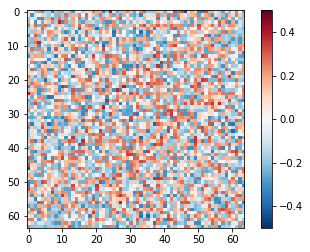

In [11]:
plt.imshow(((heatmaptest)),interpolation='nearest',vmin=-0.5,vmax=0.5,cmap=plt.cm.RdBu_r)
plt.colorbar()


In [ ]:
from nilearn.plotting import plot_connectome

plot_connectome((heatmaptest),allcoords,edge_threshold = '99%')

